In [3]:
import pandas as pd
import numpy as np
import re, os, requests
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

import gensim
from nltk import word_tokenize, pos_tag
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline

/Users/piocalderon/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Part 1: Web Scraping
**Task**: Scrape movie box office performance and metadata from boxofficemojo.com

**Timeframe Considered**: 2010-2018 (5645 movies)

In [825]:
def get_film_metadata(url_string):
    """
        Obtain movie metadata from the url of a movie's page
        
        Input:
            url_string : movie metadata url
        Output:
            movie_dict : dictionary of movie information
    """
    
    url = requests.get(url_string)
    bs = BeautifulSoup(url.content, 'lxml')  
    
    # select table of metadata information 
    entries = bs.select('center td')
    
    # table entries are in the form 'label: xxx'
    # retain only xxx
    remove_label = lambda x: x[x.find(':') + 2:]
    
    # get list of metadata values
    fixed_entries = [remove_label(entry.text) for entry in entries]
    # get list of metadata labels
    meta_labels = ['total_gross', 'distributor', 'release_date', 'genre', 'runtime', 'rating', 'budget']
                       
    # combine values and labels to a dict
    metadata_dict = dict(zip(meta_labels, fixed_entries))
                       
    return metadata_dict

In [826]:
def process_row(row, base):
    """
        Process a single row in the movie performance table
        
        Input:
            row : bs4 element representing the row of the table
            base : root link of website (to combine with metadata link)
        Output:
            movie_dict : dictionary of movie information
    """
    
    tds = row.select('td')
    
    # construct movie performance dictionary
    performance_dict = {'rank': int(tds[0].text),
            'movie_title': tds[1].text,
            'studio': tds[2].text,
            'adjusted_total_gross': tds[3].text,
            'theaters_gross': tds[4].text,
            'adjusted_opening': tds[5].text,
            'theaters_opening': tds[6].text,
            'open': tds[7].text,
            'close': tds[8].text}
    
    # check whether movie page exists
    try:
        # get link to movie information page
        metadata_link = tds[1].select('a')[0].get('href')
        
        # construct metadata dictionary
        metadata_dict = get_film_metadata(base + metadata_link)
        
        # combine movie performance and metadata
        movie_dict = {**performance_dict, **metadata_dict}
    except:
        movie_dict = performance_dict
        
    return movie_dict

In [827]:
def get_movie_df_for_year_k(k):
    """
        Get the dataframe of movies (including metadata) ranked by box office performance
        for the year k
        
        Input:
            k : year to obtain movies
        Output:
            movie_df : Pandas dataframe with box office performance and movie metadata for year k
    """
    
    # root url
    base = 'http://www.boxofficemojo.com'
    
    # initialize scraping with the first page
    # always adjust prices to 2018 so that we can ignore the effect of inflation
    url = requests.get('http://www.boxofficemojo.com/yearly/chart/?yr={}&p=.htm&adjust_yr=2018'.format(k))
    bs = BeautifulSoup(url.content, 'lxml')
    # get table containing movie data
    table = bs.find_all('table', bgcolor='#ffffff')[0]
    # extract only rows with movies
    rows = table.select('tr')[2:-4]
    movie_df = pd.DataFrame([process_row(row, base) for row in rows])

    # obtain a list of urls to pass through
    next_links = [x.get('href') + '&adjust_yr=2016' for x in bs.select('center')[0].select('a')]
    
    # iterate over the next pages
    for link in next_links:
        url = requests.get(base + link)
        bs = BeautifulSoup(url.content, 'lxml')
        table = bs.find_all('table', bgcolor='#ffffff')[0]
        rows = table.select('tr')[2:-4]
        next_df = pd.DataFrame([process_row(row, base) for row in rows])
        
        # concatenate new movie dataframe with the previous one
        movie_df = pd.concat([movie_df, next_df], ignore_index=True)
        
    movie_df['year'] = k
    
    return movie_df

In [306]:
# iterate over 2010 to 2018
# might take a long time since we are accessing metadata page for each movie
for k in [2017]:
    movie_df = get_movie_df_for_year_k(k)
    # save yearly data frame as a csv file for further cleaning
    movie_df.to_csv('data/priorcleaning_{}.csv'.format(k), index=False)
    print('{} done!'.format(k))

2017 done!


# Part 2: Data Cleaning and Feature Engineering
**Tasks**: 
* Consolidate all dataframes. 
* Convert strings to floats and date strings to date objects for further analysis
* Obtain NLP features and Average Word Vectors

In [4]:
# Collect all data across years into a dataframe called pc
pc = pd.DataFrame()
for file in [x for x in sorted(os.listdir('data')) if x.endswith('.csv')]:
    pc = pd.concat([pc, pd.read_csv('data/' + file)], ignore_index=True)

In [861]:
# Remove dollar symbols, commas, and convert amounts to floats
pc['adjusted_opening'] = pc['adjusted_opening'].str.replace('[$,]', '').astype(float)
pc['adjusted_total_gross'] = pc['adjusted_total_gross'].str.replace('[$,]', '').astype(float)
pc['budget'] = pc['budget'].str.replace('[$,]', '').map(lambda x: x if pd.isnull(x) else ( \
        float(re.findall(r'[0-9]+', x)[0])*1000000 if \
        str(x)[-7:] == 'million' else float(re.findall(r'[0-9]+', x)[0]))).astype(float)
pc['theaters_opening'] = pc['theaters_opening'].str.replace(',', '').astype(float)
pc['theaters_gross'] = pc['theaters_gross'].str.replace(',', '').astype(float)

# Total gross is a delnquent column: it has some text, so we extract the first numerical value
pc['total_gross'] = pc['total_gross'].str.replace('[$,]', '').str.extract(r'([0-9]+)', expand=False).astype(float)

In [862]:
pc['adjusted_opening_per_cinema'] = pc['adjusted_opening'] / pc['theaters_opening']
pc['adjusted_total_gross_per_cinema'] = pc['adjusted_total_gross'] / pc['theaters_gross']
pc['total_gross_per_cinema'] = pc['total_gross'] / pc['theaters_gross']

In [863]:
with_close = pc['close'] == '-'

In [864]:
pc['close'][with_close] = np.nan

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [865]:
# Convert open and close to datetime objects
pc['open'] = pd.to_datetime(pc['year'].astype(str) + '/' + pc['open'])
pc['close'] = pd.to_datetime(pc['year'].astype(str) + '/' + pc['close'])

In [866]:
to_add_year = (pc['close'] < pc['open'])
#pc['close'][to_add_year] = pc['close'][to_add_year].dt

In [867]:
pc['close'][to_add_year] = pc['close'][to_add_year] + pd.Timedelta(days=365)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [868]:
pc['in_cinema'] = (pc['close'] - pc['open']).dt.days

In [869]:
# Convert runtime to minutes
temp_runtime = pc['runtime'].str.extract(r'(?P<hour>[0-9]+)[a-zA-Z .]+(?P<minute>[0-9]+)', expand=False)
pc['runtime'] = temp_runtime['hour'].astype(float)*60 + temp_runtime['minute'].astype(float)

In [870]:
# extract genres from genre string
with_genre = ~pd.isnull(pc['genre'])
pc[['genre1', 'genre2']] = pd.DataFrame(pc['genre'][with_genre].str.replace('/', '').str.split().values.tolist(), pc[with_genre].index).add_prefix('genre_')
pc['genre2'][pd.isnull(pc['genre2'])] = np.nan

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [871]:
pc['movie_title'] = pc['movie_title'].str.replace('\(.+\)', '').str.strip()

In [872]:
pc['distributor'] = pc['distributor'].str.replace('\(.+\)', '').str.strip()

In [873]:
pc['tokenized_words'] = pc['movie_title'].str.replace(r'[^a-zA-Z0-9\' ]', '').map(word_tokenize)

In [874]:
pc['num_tokens'] = pc['tokenized_words'].map(lambda x: len(x))

In [875]:
# get POS tags to extract POS frequencies
tagged = pc['tokenized_words'].map(pos_tag)

In [876]:
pc['num_nouns'] = tagged.map(lambda pairs: len([pair for pair in pairs if pair[1].startswith('NN')]))
pc['frac_nouns'] = pc['num_nouns'] / pc['num_tokens']

In [877]:
pc['num_verbs'] = tagged.map(lambda pairs: len([pair for pair in pairs if pair[1].startswith('VB')]))
pc['frac_verbs'] = pc['num_verbs'] / pc['num_tokens']

In [878]:
pc['num_adjectives'] = tagged.map(lambda pairs: len([pair for pair in pairs if pair[1].startswith('JJ')]))
pc['frac_adjectives'] = pc['num_adjectives'] / pc['num_tokens']

In [879]:
pc['num_cardinals'] = tagged.map(lambda pairs: len([pair for pair in pairs if pair[1].startswith('CD')]))
pc['frac_cardinals'] = pc['num_cardinals'] / pc['num_tokens']

In [880]:
# Define columns to retain
cols = [
        'year',
        'rank',
        'movie_title',
        'rating',
        'genre1',
        'genre2',
        'runtime',
        'distributor',
        'budget',
        'adjusted_opening',
        'adjusted_total_gross',
        'total_gross',
        'adjusted_opening_per_cinema',
        'adjusted_total_gross_per_cinema',
        'total_gross_per_cinema',
        'theaters_opening',
        'theaters_gross',
        'in_cinema',
        'open',
        'close',
        'tokenized_words',
        'num_tokens',
        'frac_nouns',
        'frac_verbs',
        'frac_adjectives',
        'frac_cardinals'
       ]

pc = pc[cols]

In [23]:
# load word embedding for Word2Vec features
# assume we have binary file of word2vec in directory
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [881]:
# add average word vector as feature
pc = pd.concat([pc, pc['tokenized_words'].map(lambda words: 
        np.sum([word_vectors[word] for word in words if word in word_vectors.vocab.keys()], axis=0)).apply(pd.Series).add_prefix('wv_')], axis=1)

In [883]:
# save cleaned df as csv
pc.to_csv('data/cleaned.csv', index=False)

# Part 3: Exploratory Data Analysis
**Tasks**:

Look at the trends for adjusted opening & total gross per cinema across
* year
* genre
* rating
* runtime
* distributor
* budget
* duration showing
* NLP feature counts

In [5]:
# if skipping Parts 1-2, just run this code block to get the cleaned dataframe
pc = pd.read_csv('data/cleaned.csv')
pc['tokenized_words'] = pc['movie_title'].str.replace(r'[^a-zA-Z0-9\' ]', '').map(word_tokenize)

## Performance vs Year

/Users/piocalderon/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


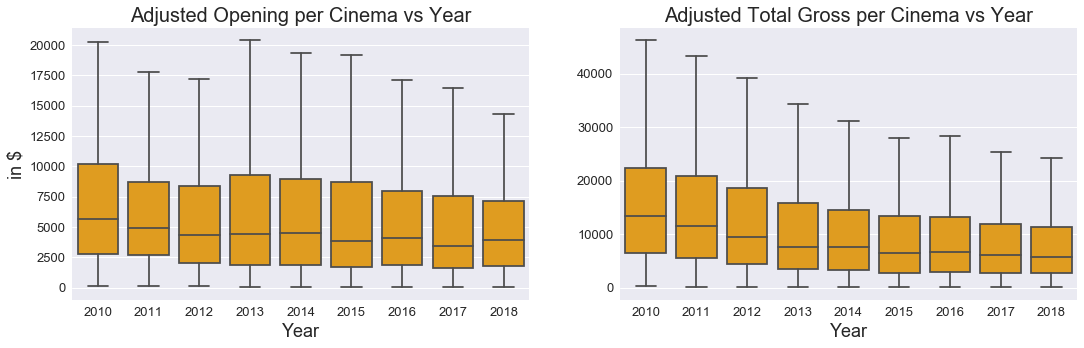

In [6]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.boxplot(x = 'year', y = 'adjusted_opening_per_cinema', showfliers = False, color = 'orange', data = pc)
plt.title("Adjusted Opening per Cinema vs Year", size=20)
plt.xlabel('Year', size=18)
plt.xticks(rotation=0, size=13)
plt.ylabel('in $', size=18)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.boxplot(x = 'year', y = 'adjusted_total_gross_per_cinema', showfliers = False, color = 'orange', data = pc)
plt.title("Adjusted Total Gross per Cinema vs Year", size=20)
plt.xlabel('Year', size=18)
plt.ylabel('')
plt.xticks(rotation=0, size=13)
plt.yticks(size=13);

* Adjusted opening seems to stay constant
* Adjusted total gross shows a downward trend

## Performance vs Genre

/Users/piocalderon/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


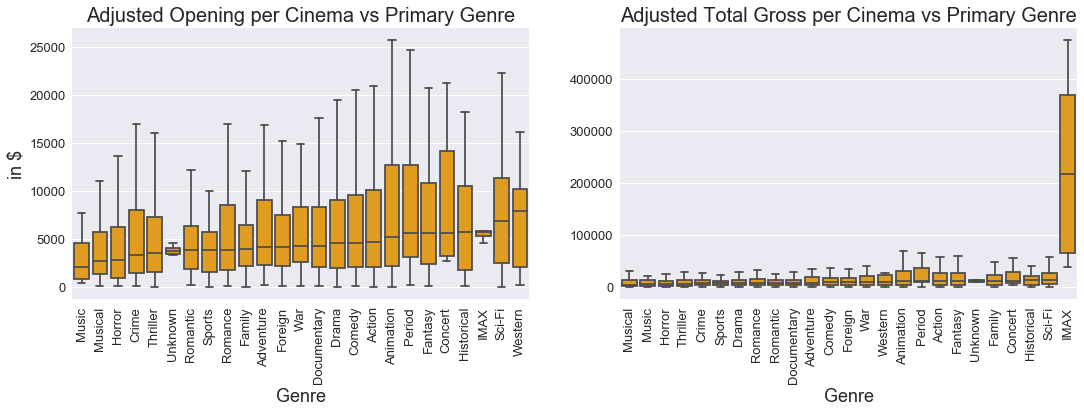

In [26]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
o1 = pc.groupby('genre1').median()['adjusted_opening_per_cinema'].sort_values().index
sns.boxplot(x = 'genre1', y = 'adjusted_opening_per_cinema', showfliers = False, color = 'orange', order = o1, data = pc)
plt.title("Adjusted Opening per Cinema vs Primary Genre", size=20)
plt.xlabel('Genre', size=18)
plt.xticks(size=13, rotation=90)
plt.ylabel('in $', size=18)
plt.yticks(size=13)

ax = fig.add_subplot(122)
o2 = pc.groupby('genre1').median()['adjusted_total_gross_per_cinema'].sort_values().index
sns.boxplot(x = 'genre1', y = 'adjusted_total_gross_per_cinema', showfliers = False, color = 'orange', order = o2, data = pc)
plt.title("Adjusted Total Gross per Cinema vs Primary Genre", size=20)
plt.xlabel('Genre', size=18)
plt.ylabel('')
plt.xticks(size=13, rotation=90)
plt.yticks(size=13);

* Western, Sci Fi, IMAX have highest median opening performance, while musicals and horror seem to perform badly on opening
* IMAX dominates adjusted total gross, followed by scifi and historical

## Performance vs Rating

/Users/piocalderon/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


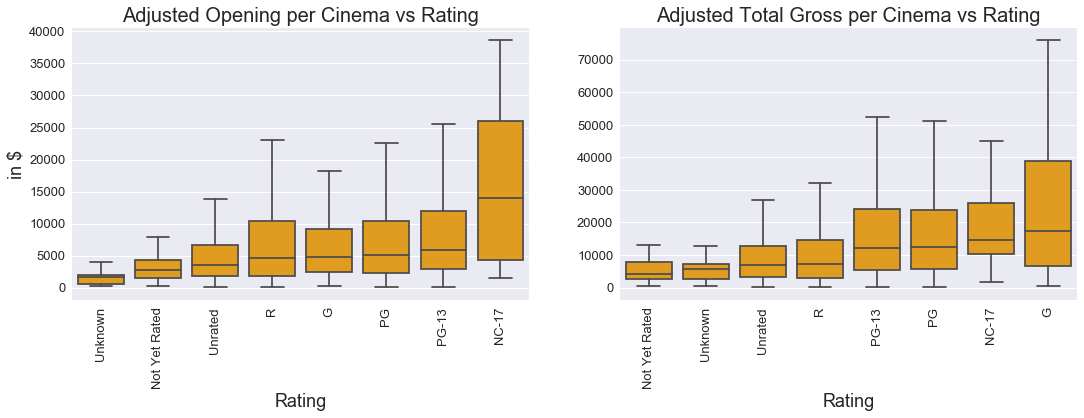

In [27]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
o1 = pc.groupby('rating').median()['adjusted_opening_per_cinema'].sort_values().index
sns.boxplot(x = 'rating', y = 'adjusted_opening_per_cinema', showfliers = False, color = 'orange', order = o1, data = pc)
plt.title("Adjusted Opening per Cinema vs Rating", size=20)
plt.xlabel('Rating', size=18)
plt.xticks(size=13, rotation=90)
plt.ylabel('in $', size=18)
plt.yticks(size=13)

ax = fig.add_subplot(122)
o2 = pc.groupby('rating').median()['adjusted_total_gross_per_cinema'].sort_values().index
sns.boxplot(x = 'rating', y = 'adjusted_total_gross_per_cinema', showfliers = False, color = 'orange', order = o2, data = pc)
plt.title("Adjusted Total Gross per Cinema vs Rating", size=20)
plt.xlabel('Rating', size=18)
plt.ylabel('')
plt.xticks(size=13, rotation=90)
plt.yticks(size=13);

* NC-17 has highest median adjusted opening
* G has highest adjusted total gross

## Performance vs Runtime

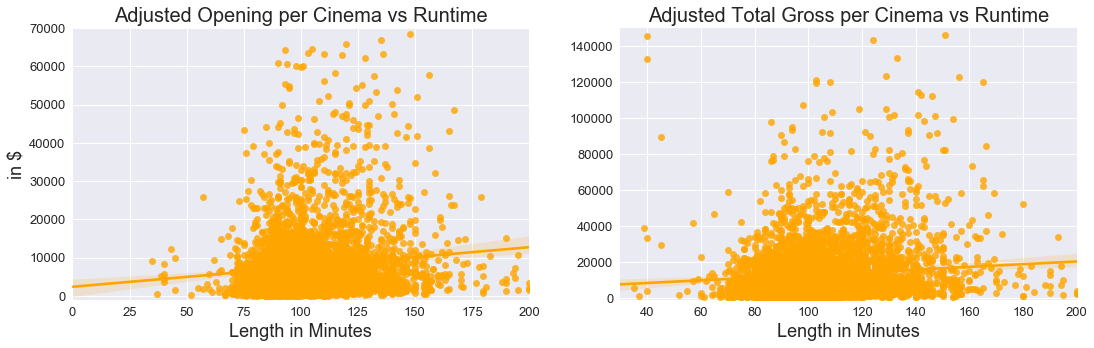

In [28]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.regplot(x = 'runtime', y = 'adjusted_opening_per_cinema', color = 'orange', data = pc)
plt.xlim(0, 200)
plt.ylim(-1000, 70000)
plt.title("Adjusted Opening per Cinema vs Runtime", size=20)
plt.xlabel('Length in Minutes', size=18)
plt.ylabel('in $', size=18)
plt.xticks(size=13)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.regplot(x = 'runtime', y = 'adjusted_total_gross_per_cinema', color = 'orange', data = pc)
plt.xlim(30, 200)
plt.ylim(-1000,150000)
plt.title("Adjusted Total Gross per Cinema vs Runtime", size=20)
plt.xlabel('Length in Minutes', size=18)
plt.ylabel('')
plt.xticks(size=13)
plt.yticks(size=13);

* Most successful movies tend to fall between 75 to 150 minutes in length

## Performance vs Distributor

/Users/piocalderon/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/piocalderon/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


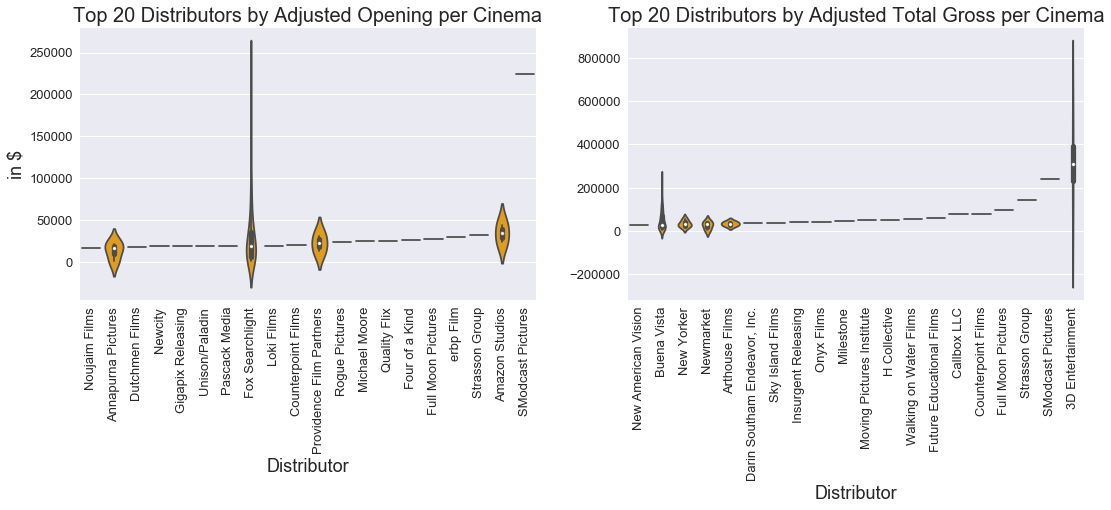

In [29]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
o1 = pc.groupby('distributor').median()['adjusted_opening_per_cinema'].dropna().sort_values().index[-20:]
dist1 = pc[pc['distributor'].isin(o1)]
sns.violinplot(x = 'distributor', y = 'adjusted_opening_per_cinema', showfliers = False, color = 'orange', order = o1, data = dist1)
plt.title("Top 20 Distributors by Adjusted Opening per Cinema", size=20)
plt.xlabel('Distributor', size=18)
plt.xticks(size=13, rotation=90)
plt.ylabel('in $', size=18)
plt.yticks(size=13)

ax = fig.add_subplot(122)
o2 = pc.groupby('distributor').median()['adjusted_total_gross_per_cinema'].dropna().sort_values().index[-20:]
dist2 = pc[pc['distributor'].isin(o2)]
sns.violinplot(x = 'distributor', y = 'adjusted_total_gross_per_cinema', showfliers = False, color = 'orange', order = o2, data = dist2)
plt.title("Top 20 Distributors by Adjusted Total Gross per Cinema", size=20)
plt.xlabel('Distributor', size=18)
plt.ylabel('')
plt.xticks(size=13, rotation=90)
plt.yticks(size=13);

## Performance vs Budget

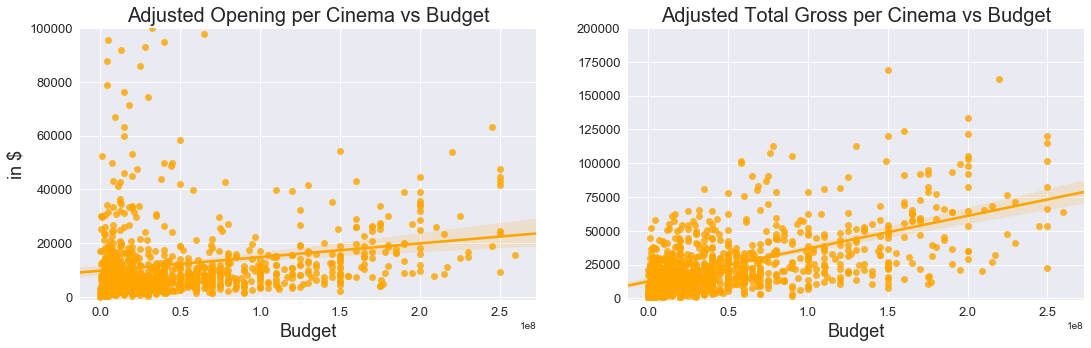

In [30]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.regplot(x = 'budget', y = 'adjusted_opening_per_cinema', color = 'orange', data = pc)
plt.ylim(-1000,100000)
plt.title("Adjusted Opening per Cinema vs Budget", size=20)
plt.xlabel('Budget', size=18)
plt.ylabel('in $', size=18)
plt.xticks(size=13)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.regplot(x = 'budget', y = 'adjusted_total_gross_per_cinema', color = 'orange', data = pc)
plt.ylim(-1000,200000)
plt.title("Adjusted Total Gross per Cinema vs Budget", size=20)
plt.xlabel('Budget', size=18)
plt.ylabel('')
plt.xticks(size=13)
plt.yticks(size=13);

* Some small-budget films with good opening performance (ex. Kings Speech, Black Swan, The Fighter)
* Some high-budget films with bad opening performance (ex. Tangled, Pirates of the Caribbean: On Stranger Tides	)
* Faint positive relation between budget and box office performance

## Performance vs Duration in Theater

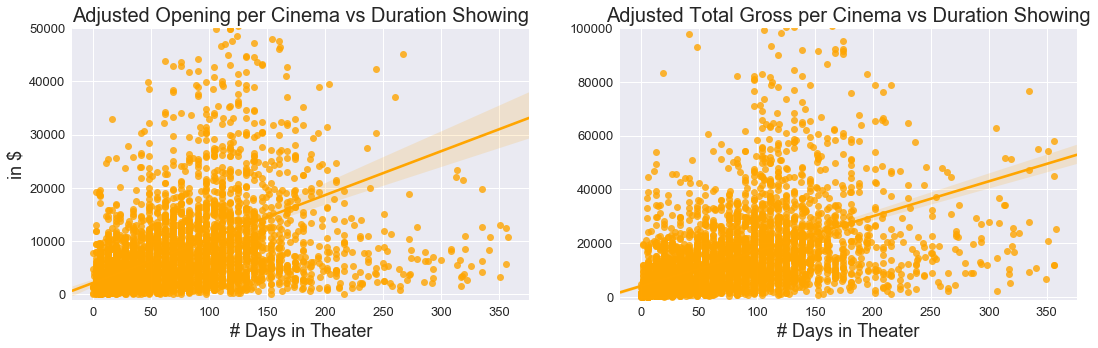

In [31]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.regplot(x = 'in_cinema', y = 'adjusted_opening_per_cinema', color = 'orange', data = pc)
plt.ylim(-1000,50000)
plt.title("Adjusted Opening per Cinema vs Duration Showing", size=20)
plt.xlabel('# Days in Theater', size=18)
plt.ylabel('in $', size=18)
plt.xticks(size=13)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.regplot(x = 'in_cinema', y = 'adjusted_total_gross_per_cinema', color = 'orange', data = pc)
plt.ylim(-1000,100000)
plt.title("Adjusted Total Gross per Cinema vs Duration Showing", size=20)
plt.xlabel('# Days in Theater', size=18)
plt.ylabel('')
plt.xticks(size=13)
plt.yticks(size=13);

* Very faint positive relation between budget and duration showing

## NLP Features

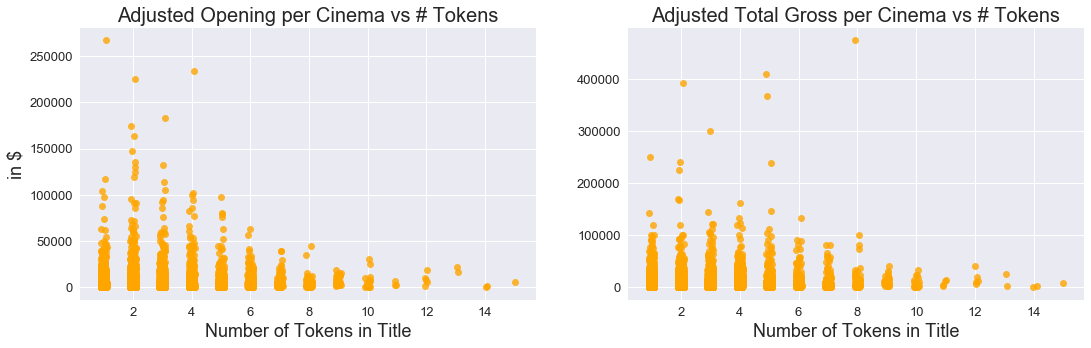

In [32]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.regplot(x = 'num_tokens', y = 'adjusted_opening_per_cinema', x_jitter=0.1, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Opening per Cinema vs # Tokens", size=20)
plt.xlabel('Number of Tokens in Title', size=18)
plt.ylabel('in $', size=18)
plt.xticks(size=13)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.regplot(x = 'num_tokens', y = 'adjusted_total_gross_per_cinema', x_jitter=0.1, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Total Gross per Cinema vs # Tokens", size=20)
plt.xlabel('Number of Tokens in Title', size=18)
plt.ylabel('')
plt.xticks(size=13)
plt.yticks(size=13);

* Interestingly, we see higher variance for small number of tokens
* Higher performance associated with lower # of tokens

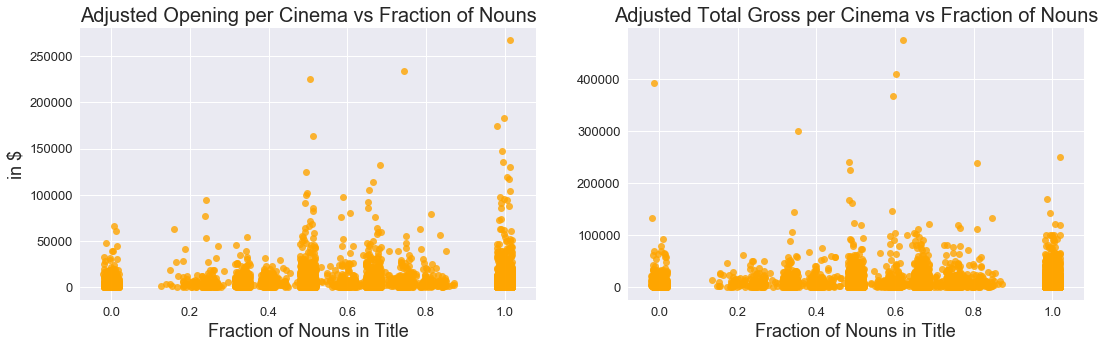

In [33]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.regplot(x = 'frac_nouns', y = 'adjusted_opening_per_cinema', x_jitter=0.02, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Opening per Cinema vs Fraction of Nouns", size=20)
plt.xlabel('Fraction of Nouns in Title', size=18)
plt.ylabel('in $', size=18)
plt.xticks(size=13)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.regplot(x = 'frac_nouns', y = 'adjusted_total_gross_per_cinema', x_jitter=0.02, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Total Gross per Cinema vs Fraction of Nouns", size=20)
plt.xlabel('Fraction of Nouns in Title', size=18)
plt.ylabel('')
plt.xticks(size=13)
plt.yticks(size=13);

* No apparent trend for fraction of nouns.

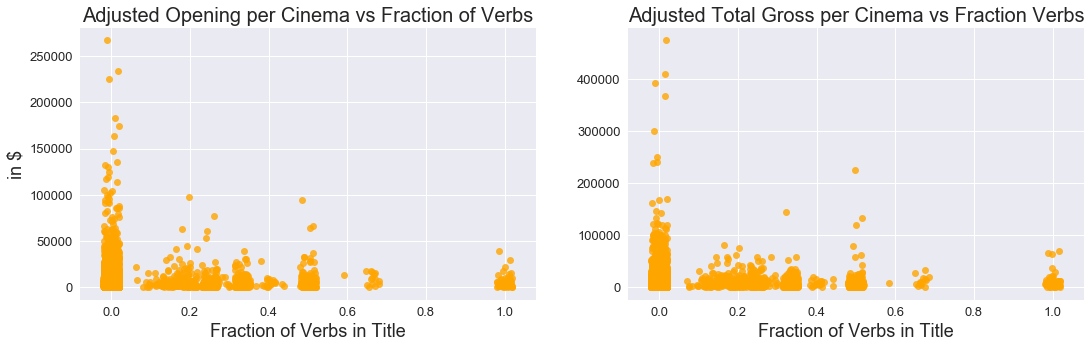

In [34]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.regplot(x = 'frac_verbs', y = 'adjusted_opening_per_cinema', x_jitter=0.02, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Opening per Cinema vs Fraction of Verbs", size=20)
plt.xlabel('Fraction of Verbs in Title', size=18)
plt.ylabel('in $', size=18)
plt.xticks(size=13)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.regplot(x = 'frac_verbs', y = 'adjusted_total_gross_per_cinema', x_jitter=0.02, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Total Gross per Cinema vs Fraction Verbs", size=20)
plt.xlabel('Fraction of Verbs in Title', size=18)
plt.ylabel('')
plt.xticks(size=13)
plt.yticks(size=13);

* Low verb count is associated with higher variability in box office performance

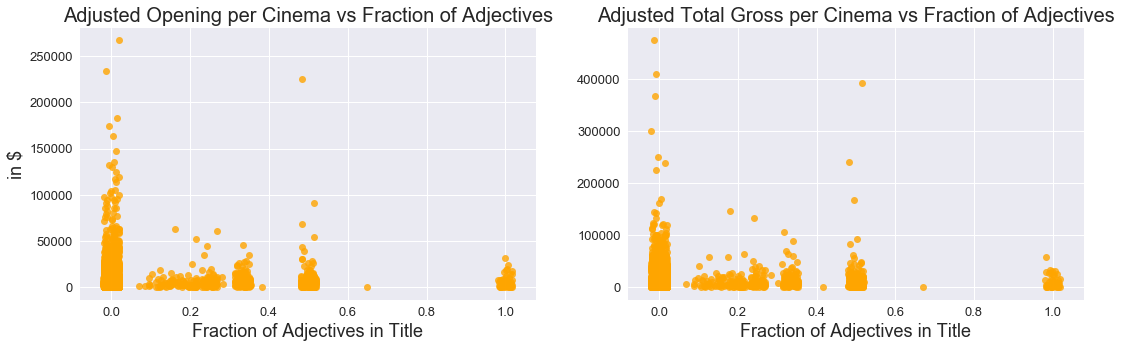

In [35]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.regplot(x = 'frac_adjectives', y = 'adjusted_opening_per_cinema', x_jitter=0.02, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Opening per Cinema vs Fraction of Adjectives", size=20)
plt.xlabel('Fraction of Adjectives in Title', size=18)
plt.ylabel('in $', size=18)
plt.xticks(size=13)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.regplot(x = 'frac_adjectives', y = 'adjusted_total_gross_per_cinema', x_jitter=0.02, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Total Gross per Cinema vs Fraction of Adjectives", size=20)
plt.xlabel('Fraction of Adjectives in Title', size=18)
plt.ylabel('')
plt.xticks(size=13)
plt.yticks(size=13);

* Low adjective count is associated with higher variability in box office performance

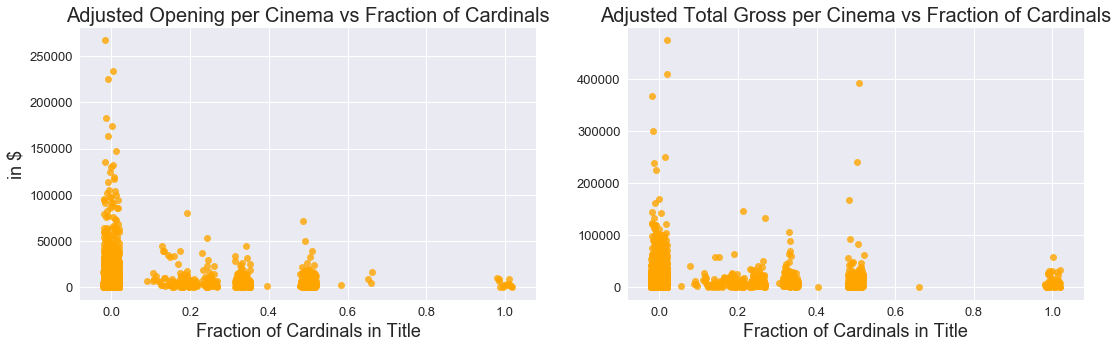

In [36]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(121)
sns.regplot(x = 'frac_cardinals', y = 'adjusted_opening_per_cinema', x_jitter=0.02, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Opening per Cinema vs Fraction of Cardinals", size=20)
plt.xlabel('Fraction of Cardinals in Title', size=18)
plt.ylabel('in $', size=18)
plt.xticks(size=13)
plt.yticks(size=13)

ax = fig.add_subplot(122)
sns.regplot(x = 'frac_adjectives', y = 'adjusted_total_gross_per_cinema', x_jitter=0.02, color = 'orange', data = pc, fit_reg=False)
plt.title("Adjusted Total Gross per Cinema vs Fraction of Cardinals", size=20)
plt.xlabel('Fraction of Cardinals in Title', size=18)
plt.ylabel('')
plt.xticks(size=13)
plt.yticks(size=13);

* Low cardinal count is associated with higher variability in box office performance

## Word Clouds per Genre

In [131]:
# Let us look at the most frequently-occuring title words for best- 
# and worst-performing movies for the 5 genres with most number of movies
pc.groupby('genre1').count()['year'].sort_values(ascending=False).head()

genre1
Drama          1121
Documentary    1061
Foreign         766
Comedy          750
Action          388
Name: year, dtype: int64

In [793]:
def plot_best_and_worst_words_per_genre(genre = '', var = 'adjusted_total_gross_per_cinema'):
    
    if genre == '':
        genre_df = pc.dropna(subset = [var]).sort_values(var)
    else:
        genre_df = pc[pc['genre1'] == genre].dropna(subset = [var]).sort_values(var)
    worst = ' '.join(genre_df.head(100)['movie_title'].values)
    best = ' '.join(genre_df.tail(100)['movie_title'].values)

    wordcloud_w = WordCloud().generate(worst)
    wordcloud_b = WordCloud().generate(best)

    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.imshow(wordcloud_w, interpolation='bilinear')
    plt.title('Wordcloud of 100 worst {} films'.format(genre), size=20)
    plt.axis("off");

    plt.subplot(122)
    plt.imshow(wordcloud_b, interpolation='bilinear')
    plt.title('Wordcloud of 100 best {} films'.format(genre), size=20)
    plt.axis("off");


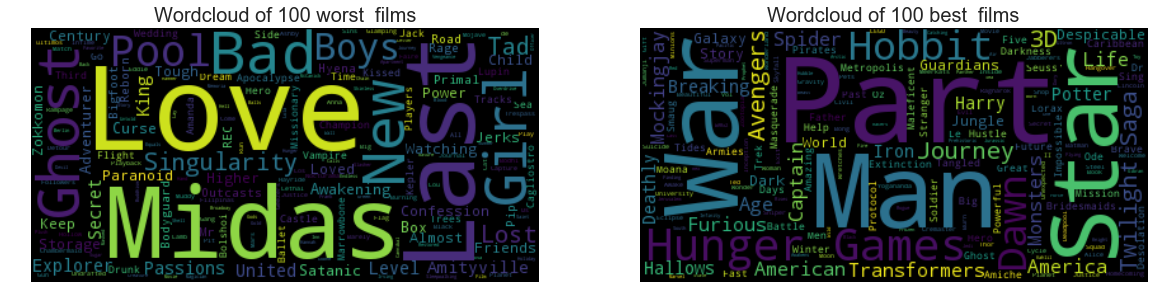

In [794]:
# Across all movies
plot_best_and_worst_words_per_genre()

* Worst words: Love, Girl, Midas, Bad
* Best words: Avengers, War, Beast, Hour

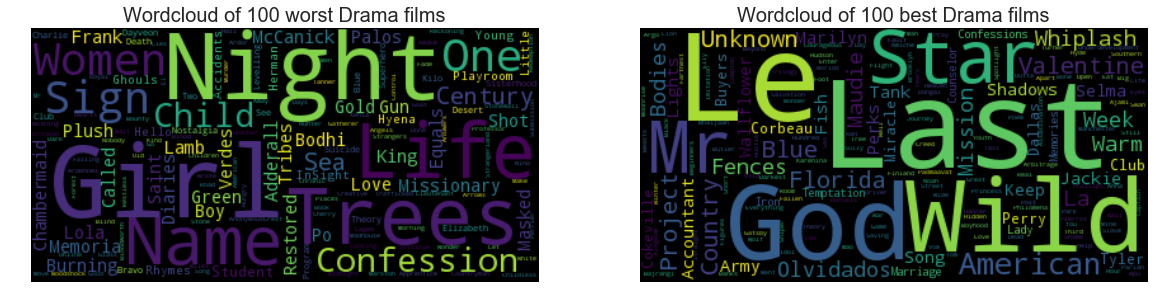

In [795]:
# Across drama films
plot_best_and_worst_words_per_genre(genre = 'Drama')

* Worst words: Night, Girl, Life, Trees
* Best words: Le, Last, God, Wild

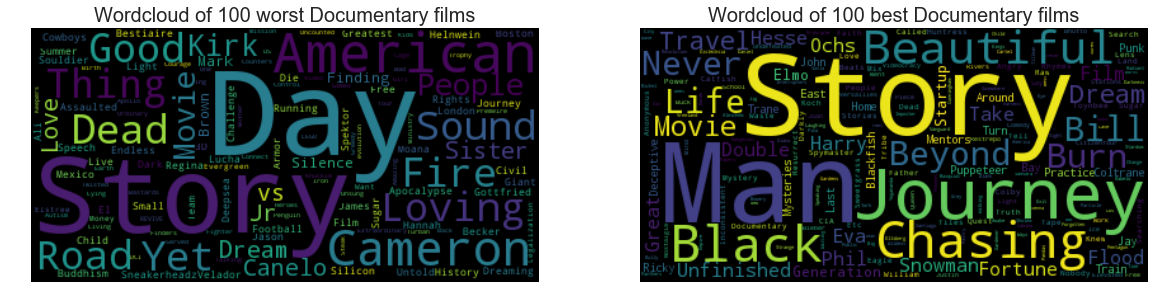

In [796]:
# Across documentary films
plot_best_and_worst_words_per_genre(genre = 'Documentary')

* Worst words: Story, Day, American
* Best words: Story, Man, Journey, Chasing

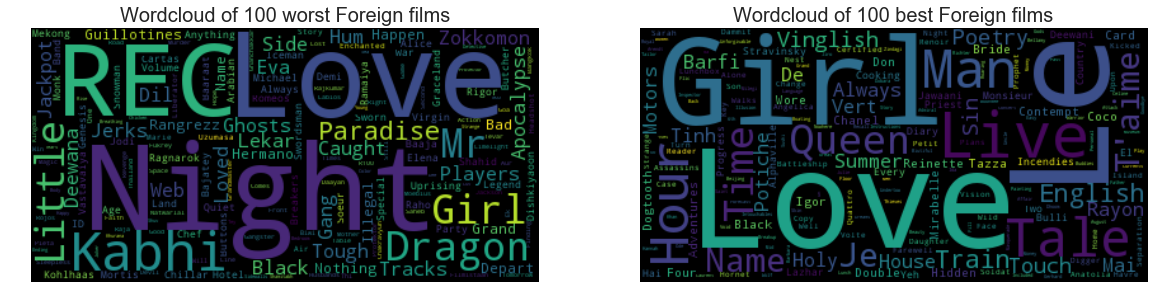

In [798]:
# Across foreign films
plot_best_and_worst_words_per_genre(genre = 'Foreign')

* Worst words: Night, Love, REC
* Best words: Girl, Love, Le

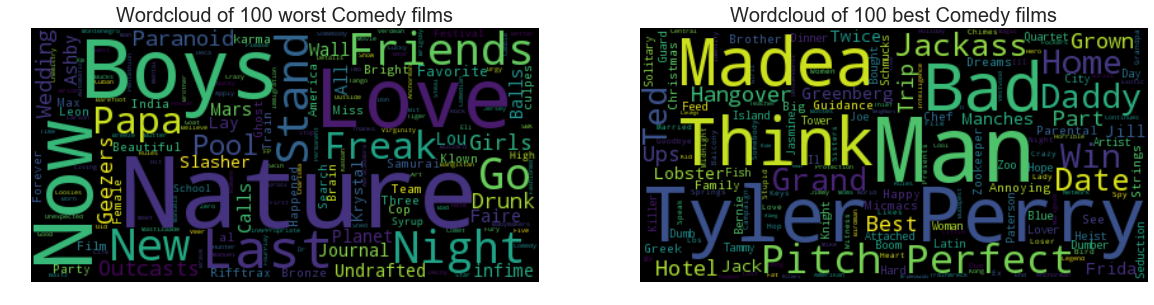

In [799]:
# Across comedy films
plot_best_and_worst_words_per_genre(genre = 'Comedy')

* Worst words: Nature, Now, Boys, Love
* Best words: Man, Tyler, Perry, Madea

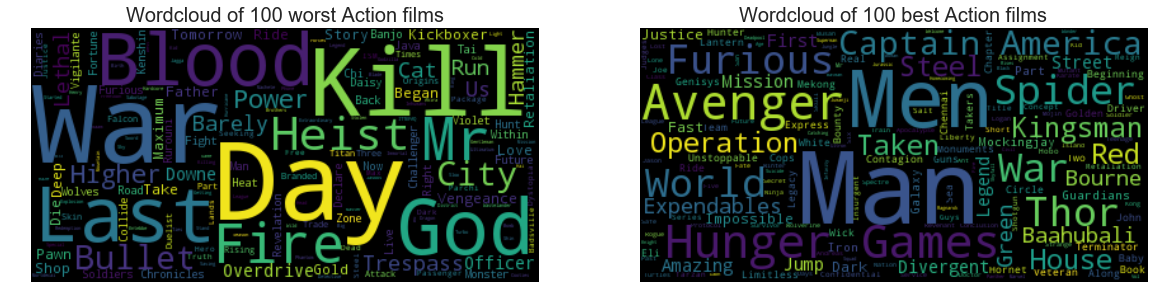

In [800]:
# Across action films
plot_best_and_worst_words_per_genre(genre = 'Action')

* Worst words: Kill, War, Last, Day
* Best words: Men, Man, Avenger

The wordclouds above show the prevalent words in the best and worst performing films per genre. Let's try to build a model to predict box office performance from title content and metadata.

# Part 4: Predict Performance Based on Word Content + Metadata
**Task**: Build a model that takes as input the words in the movie title and outputs a prediction on box office performance. Here we will consider only the adjusted total gross per cinema. Same analysis can be done for opening.

**Features Considered**:
* Metadata features
* NLP POS Frequency features
* Word2Vec word vector (300 feats)
* TF-IDF unigram and bigram features

**General Approach**: Use penalized linear regression (Ridge & Lasso) since feature space is high-dimensional and sparse. We then use the coefficient of the features to rank the features according to their effect on box office performance.

In [96]:
def split_dataset_for_genre(pc, genre = '', var = 'adjusted_total_gross_per_cinema', w2v = True, whole = False):
    """
        Split train and tests sets for the specific genre
        
        Input:
            pc : dataframe of features
            genre : genre to filter
            var : box office performance metric
            w2v : whether to include word2vec features
            whole: whether to train on whole dataset or not
        Output:
            X_train : input training set
            X_test : input test set
            y_train : output training set
            y_test : output test set
            column_names : list of feature names
    """
    
    # check whether genre is provided
    # if yes, filter pc by genre
    if genre == '':
        pc = pc
    else:
        pc = pc[pc['genre1'] == genre]
    
    # only retain rows with non-null performance metric
    pc = pc[~pc[var].isnull()]
    
    # collect metadata features
    metadata_features = pd.concat(
          [pc['runtime'],
           pc['budget'],
           pc['in_cinema'],
           pd.get_dummies(pc['rating']),
           pd.get_dummies(pc['genre1'], prefix = 'genre1'), 
           pd.get_dummies(pc['genre2'], prefix = 'genre2')
           ], axis=1)

    # collect nlp frequency features
    nlp_features = pc[['num_tokens',
        'frac_nouns',
        'frac_verbs',
        'frac_adjectives',
        'frac_cardinals',
        'movie_title']]
    
    # whether to include word2vec features
    # the w2v features tend to overpower tfidf features in the coefficients
    # of the regression
    # the point of the exercise is to see how word content correlates with box
    # office performance. it is very hard to interpret these vectors so 
    # I optional to include them
    if w2v:
        word2vec_features = pc.iloc[:,-300:]
        feature_set = [metadata_features, nlp_features, word2vec_features]
    else:
        feature_set = [metadata_features, nlp_features]
    
    X = pd.concat(feature_set, axis=1)

    if whole:
        X_train = X
        y_train = pc[var]
    else:
        # split 70-30 train test sets
        X_train, X_test, y_train, y_test = train_test_split(X,
                pc[var], test_size=0.3, random_state=0)
            
    # obtain tfidf representation for words in the training set
    # only consider up to 2-grams, and filter out tokens appearing in < 4 titles
    tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 4)
    tfidf_features = tfidf.fit_transform(X_train['movie_title'].values)
    tfidf_df = pd.DataFrame(tfidf_features.toarray(), index = X_train.index,
             columns=['word_' + x for x in tfidf.vocabulary_.keys()])
    
    # append tfidf dataframe to training df
    X_train = pd.concat([X_train, tfidf_df], axis=1)
    X_train.drop(columns=['movie_title'], inplace=True)

    column_names = X_train.columns

    pad = X_train.mean()
    
    # fill NAs with the column mean
    X_train = X_train.fillna(pad)
    
    # standardize rows
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)

    if whole:
        return X_train, None, y_train, None, column_names

    # get tfidf representation of test set
    tfidf_features_test = tfidf.transform(X_test['movie_title'].values)
    tfidf_df_test = pd.DataFrame(tfidf_features_test.toarray(), \
            index = X_test.index, columns=tfidf.vocabulary_.keys())
    
    X_test = pd.concat([X_test, tfidf_df_test], axis=1)
    X_test.drop(columns=['movie_title'], inplace=True)
    
    X_test = X_test.fillna(pad)
    X_test = ss.transform(X_test)
    
    return X_train, X_test, y_train, y_test, column_names

In [253]:
def train_model(modeltype, X_train, y_train):
    """
        Train chosen model.
        
        Input:
            modeltype : whether 'lasso' or 'ridge'
            X_train : input training set
            y_train : output training set
        Output:
            model : trained linear regression model
    """

    if modeltype == 'lasso':
        model = LassoCV()
    elif modeltype == 'ridge':
        model = RidgeCV(alphas=[0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50., 100.0])
    model.fit(X_train, y_train)
    return model

In [98]:
def evaluate_model(X, y):
    """
        Evaluate trained model.
        
        Input:
            X : input to model
            y : output to predict
    """
    
    print('R**2 : {}'.format(model.score(X, y)))
    print('RMSE : {}'.format(np.sqrt(mean_squared_error(y, model.predict(X)))))   
    plt.figure(figsize=(10,6))
    plt.plot(range(len(y)), y - model.predict(X), 'o', alpha = 0.5)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.ylabel('Residual', size=20)

In [165]:
def plot_most_relevant_features(model, column_names, n=15):
    """
        Plot the features which have the highest effect on
        box office performance based on the mode.
        
        Input:
            model : trained LR model
            column_names : list of features
            n : number of features to include (in one direction)
    """
    
    coef_sorted = list(model.coef_[np.argsort(-model.coef_)])
    columns_sorted = list(column_names[np.argsort(-model.coef_)])

    plt.figure(figsize=(10,6))
    plt.bar(range(2*n), coef_sorted[:n] + coef_sorted[-n:])
    plt.xticks(range(2*n), columns_sorted[:n] + columns_sorted[-n:], rotation=270, size=15)
    plt.yticks(size=15)
    plt.ylabel('Coefficient', size=20)
    plt.title('Top 10 + & - contributing variables', size=21);

We perform various experiments in the following:
* build model for all genres, with and without word2vec features
* build model for {Documentaries, Action}, with and without word2vec features


## Models A: All genres, no w2v features

In [188]:
# 70-30 split
X_train, X_test, y_train, y_test, _ = split_dataset_for_genre(pc, w2v=False)
# whole dataset
X, _, y, _, column_names = split_dataset_for_genre(pc, w2v=False, whole=True)

### Model A.1: Ridge

In [189]:
model = train_model('ridge', X_train, y_train);

R**2 : 0.49545826235756396
RMSE : 14242.805753041122


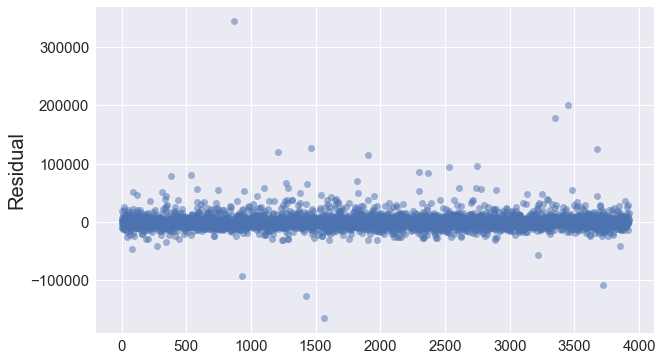

In [190]:
evaluate_model(X_train, y_train)

R**2 : 0.32814111255394207
RMSE : 16227.301254776421


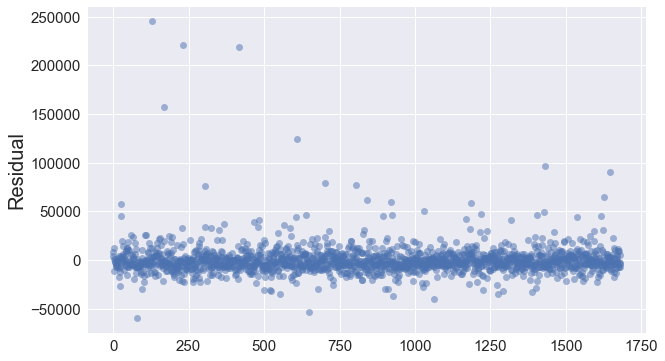

In [191]:
evaluate_model(X_test, y_test)

R**2 : 0.5187516074293146
RMSE : 13857.531665282082


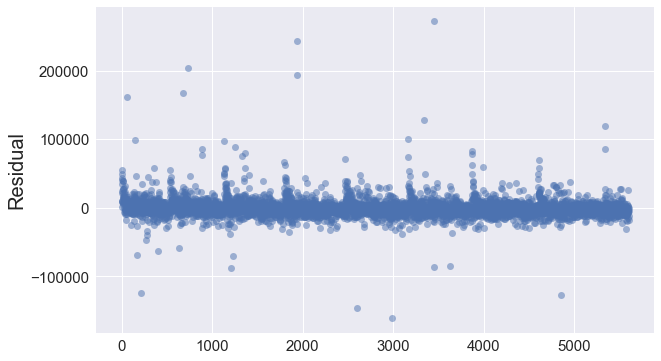

In [192]:
# train on the whole dataset
model = train_model('ridge', X, y);
evaluate_model(X, y)

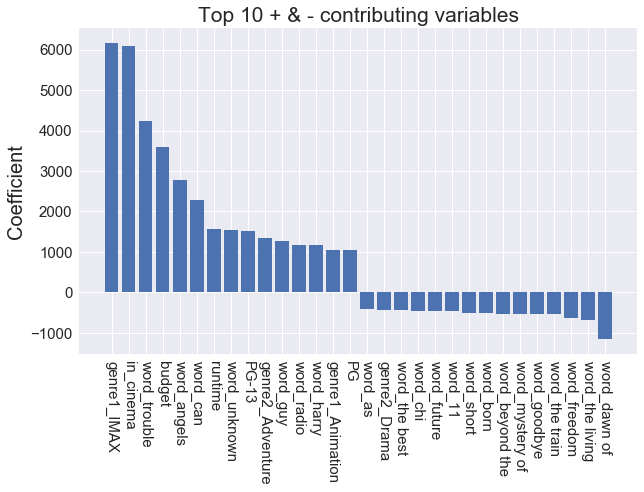

In [193]:
plot_most_relevant_features(model, column_names)

\+ coeff: trouble > angels > can > unknown

\- coeff: dawn of < the living < freedom < the train

### Model A.2: Lasso

In [194]:
model = train_model('lasso', X_train, y_train);

R**2 : 0.39480086312516355
RMSE : 15598.978231352437


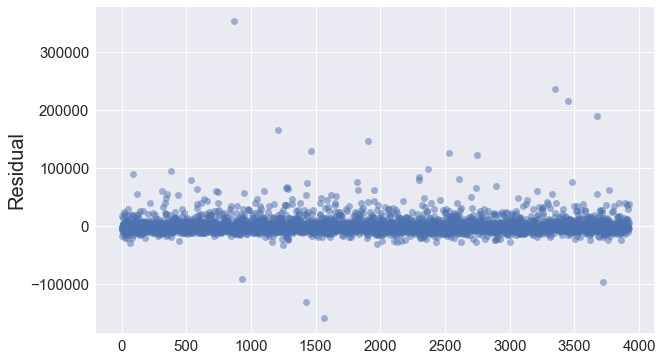

In [195]:
evaluate_model(X_train, y_train)

R**2 : 0.3396655021421685
RMSE : 16087.52589290319


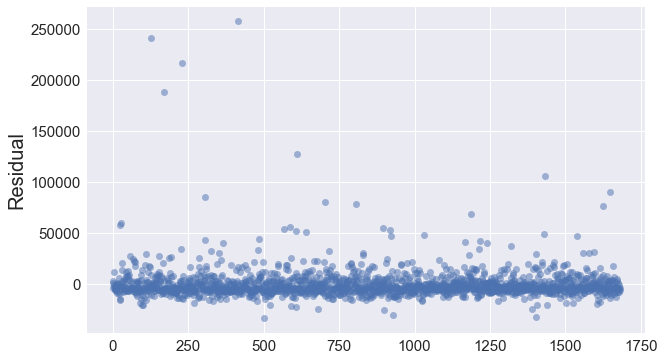

In [196]:
evaluate_model(X_test, y_test)

R**2 : 0.390910345757018
RMSE : 15589.846716015712


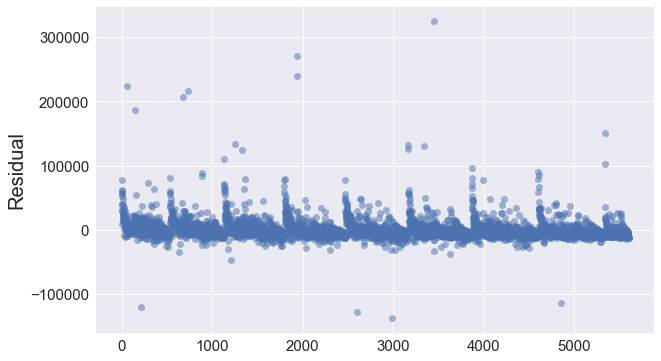

In [197]:
model = train_model('lasso', X, y);
evaluate_model(X, y)

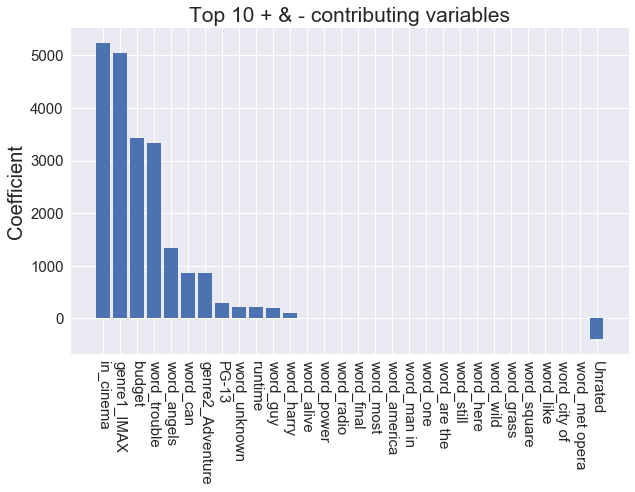

In [198]:
plot_most_relevant_features(model, column_names)

\+ coeff: trouble > angels > can

\- coeff: met opera < city of < like

## Models B: Documentary, no w2v features

In [199]:
X_train, X_test, y_train, y_test, _ = split_dataset_for_genre(pc, 'Documentary', w2v=False)
X, _, y, _, column_names = split_dataset_for_genre(pc, 'Documentary', w2v=False, whole=True)

### Model B.1: Ridge

In [200]:
model = train_model('ridge', X_train, y_train);

R**2 : 0.21482741915231962
RMSE : 18875.480098402637


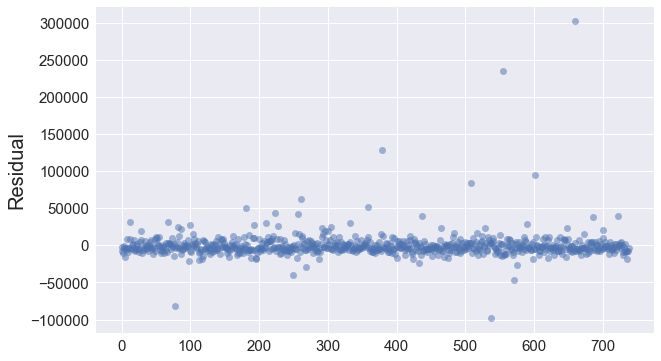

In [201]:
evaluate_model(X_train, y_train)

R**2 : -0.3586991059584401
RMSE : 18660.51993241822


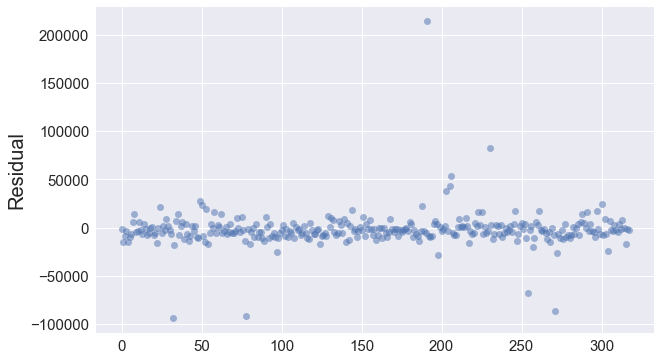

In [202]:
evaluate_model(X_test, y_test)

seems to underfit!

R**2 : 0.23664851323709046
RMSE : 17366.928666409825


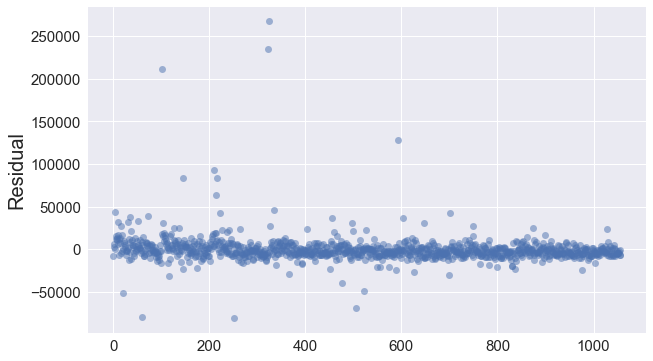

In [203]:
model = train_model('ridge', X, y);
evaluate_model(X, y)

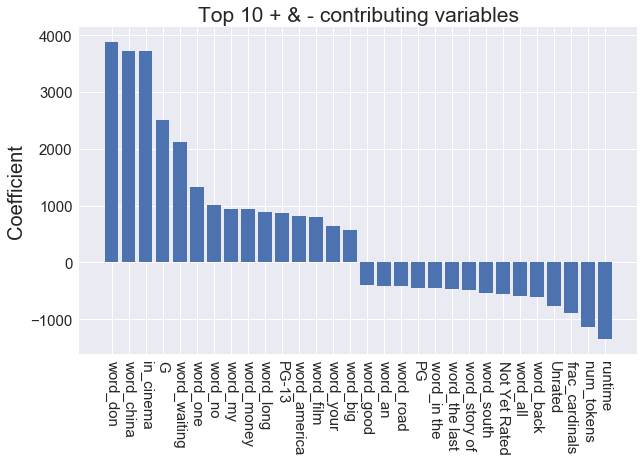

In [204]:
plot_most_relevant_features(model, column_names)

\+ coeff: don > china > waiting

\- coeff: back < all < south < story of

### Model B.2: Lasso

In [205]:
model = train_model('lasso', X_train, y_train);

R**2 : 0.0
RMSE : 21301.757883742765


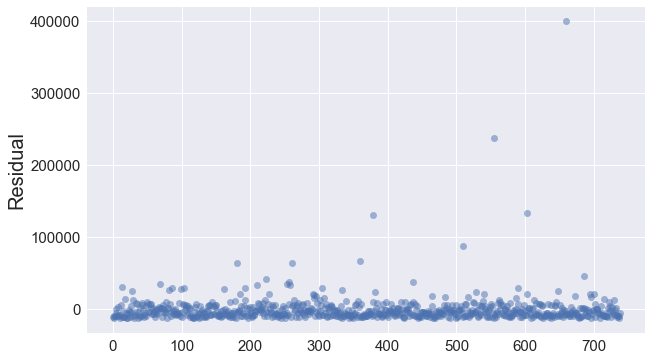

In [206]:
evaluate_model(X_train, y_train)

R**2 : -0.014102013716377646
RMSE : 16121.40609582732


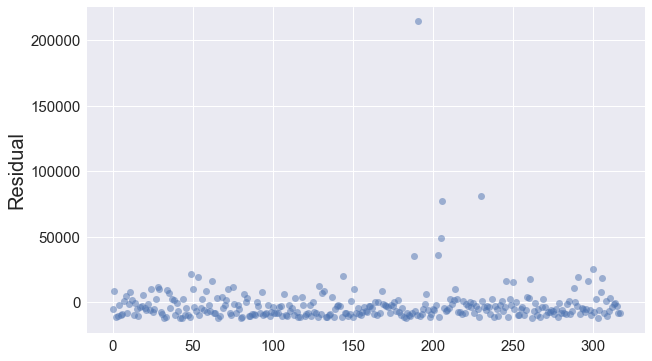

In [207]:
evaluate_model(X_test, y_test)

R**2 : 0.0
RMSE : 19877.45333446539


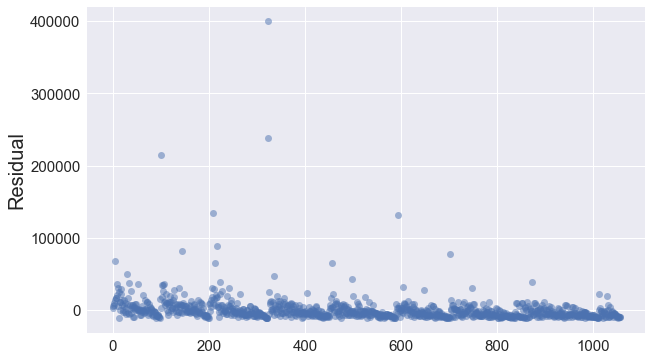

In [208]:
model = train_model('lasso', X, y);
evaluate_model(X, y)

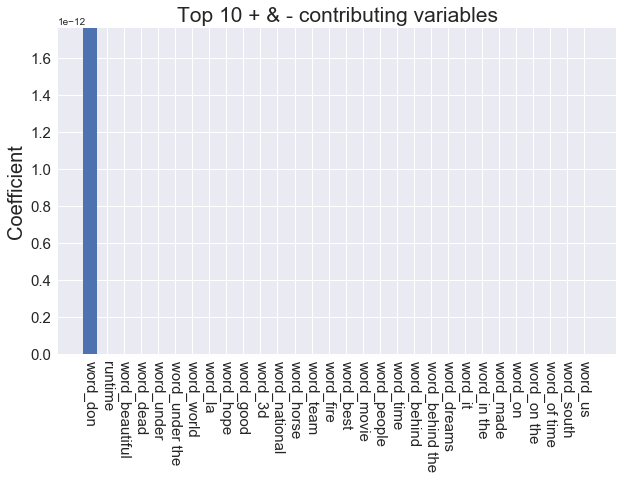

In [209]:
plot_most_relevant_features(model, column_names)

Lasso didn't fit so well on documentaries

## Models C: Action, no w2v features

In [210]:
X_train, X_test, y_train, y_test, _ = split_dataset_for_genre(pc, 'Action', w2v=False)
X, _, y, _, column_names = split_dataset_for_genre(pc, 'Action', w2v=False, whole=True)

### Model C.1: Ridge

In [211]:
model = train_model('ridge', X_train, y_train);

R**2 : 0.5822048104936064
RMSE : 17194.213356013886


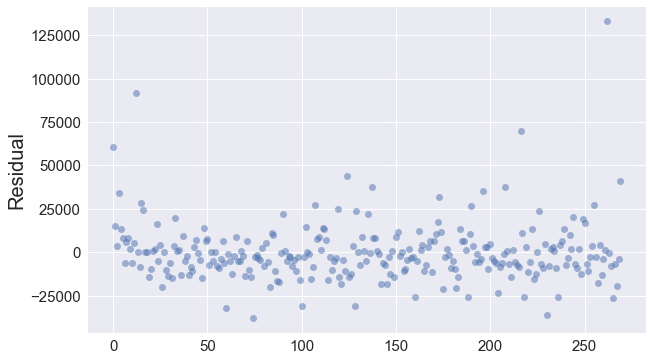

In [212]:
evaluate_model(X_train, y_train)

R**2 : 0.5596213054585182
RMSE : 19859.76627529141


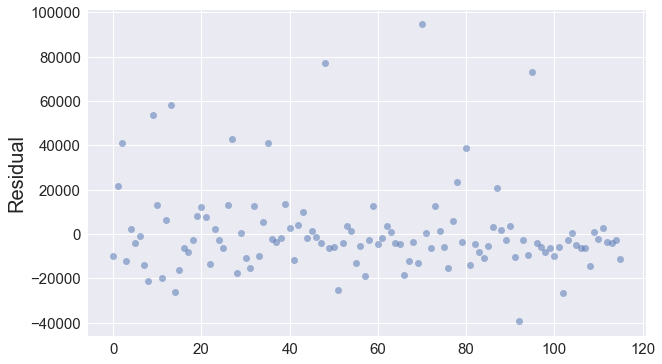

In [213]:
evaluate_model(X_test, y_test)

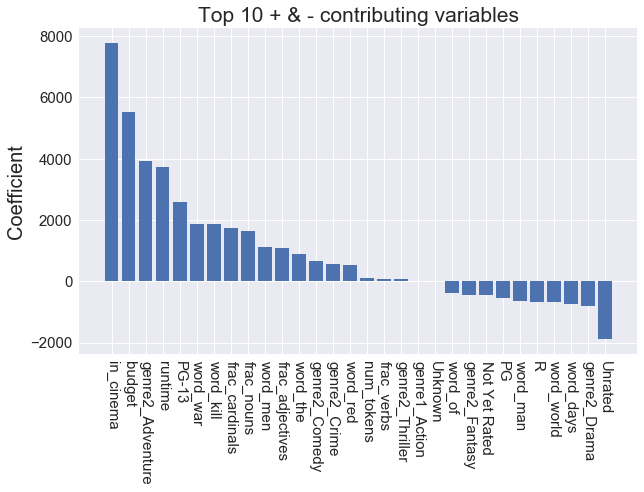

In [214]:
plot_most_relevant_features(model, column_names)

Somewhat high R^2 for action, implying that the variance in the data was captured relatively well

\+ coeff: war > kill > men

\- coeff: days < world < man

### Model C.2: Lasso

In [215]:
model = train_model('lasso', X_train, y_train);

R**2 : 0.5385787765440733
RMSE : 18069.63487299992


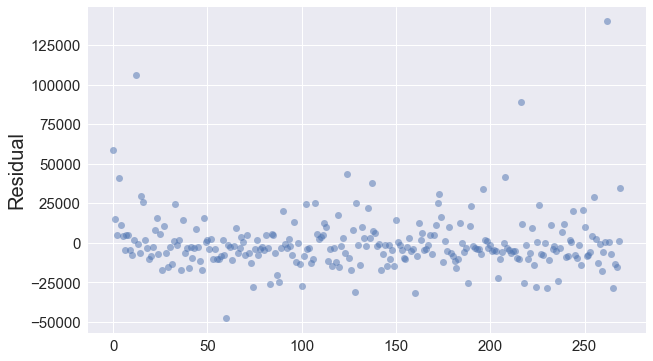

In [216]:
evaluate_model(X_train, y_train)

R**2 : 0.5940284918463846
RMSE : 19068.15882943011


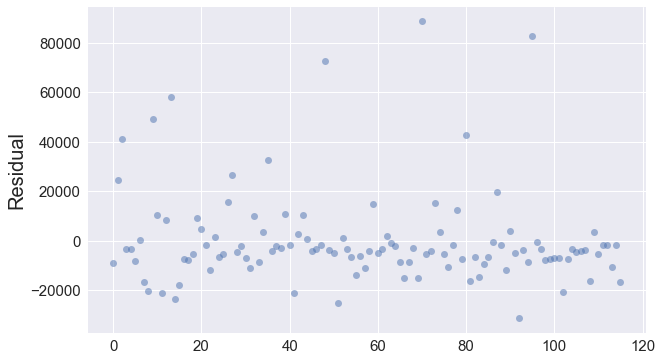

In [217]:
evaluate_model(X_test, y_test)

R**2 : 0.6002945674686648
RMSE : 17490.464353066764


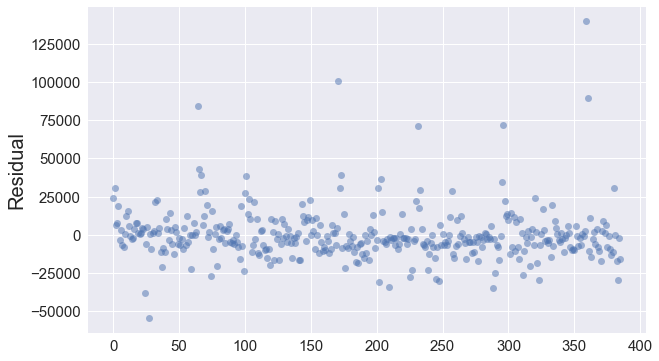

In [218]:
model = train_model('lasso', X, y);
evaluate_model(X, y)

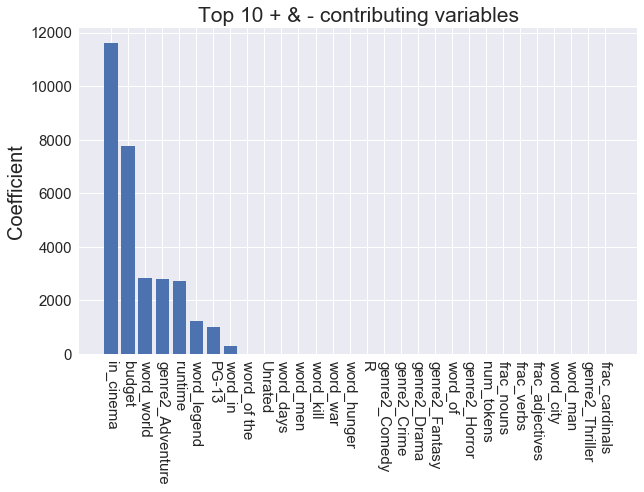

In [219]:
plot_most_relevant_features(model, column_names)

\+ coeff: legend > in

## Models D: All genres and features included

Here we include word2vec features. Note that these features seem to dominate the model coefficients

In [220]:
X_train, X_test, y_train, y_test, _ = split_dataset_for_genre(pc, w2v=True)
X, _, y, _, column_names = split_dataset_for_genre(pc, w2v=True, whole=True)

### Model D.1: Ridge

In [221]:
model = train_model('ridge', X_train, y_train);

R**2 : 0.5451899772652814
RMSE : 13522.65647171904


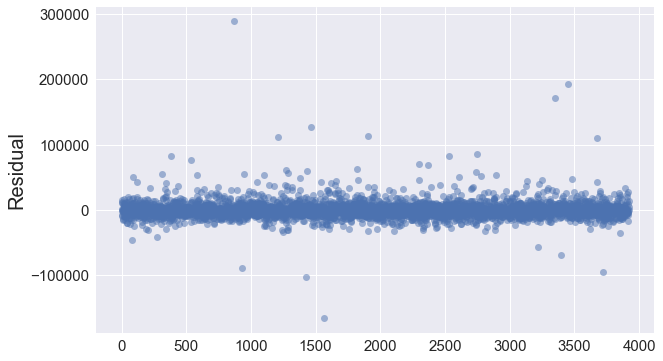

In [222]:
evaluate_model(X_train, y_train)

R**2 : 0.27225578768171743
RMSE : 16888.716504983313


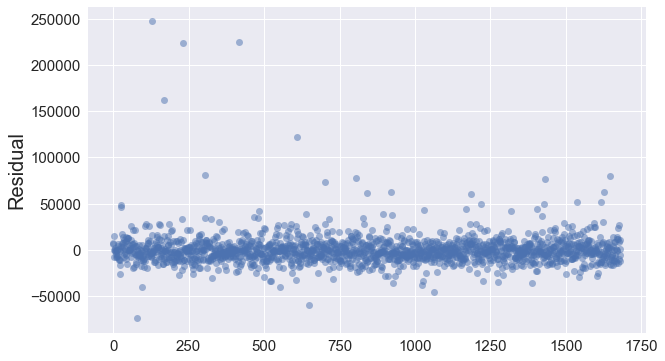

In [223]:
evaluate_model(X_test, y_test)

R**2 : 0.5508793416739061
RMSE : 13386.984163739326


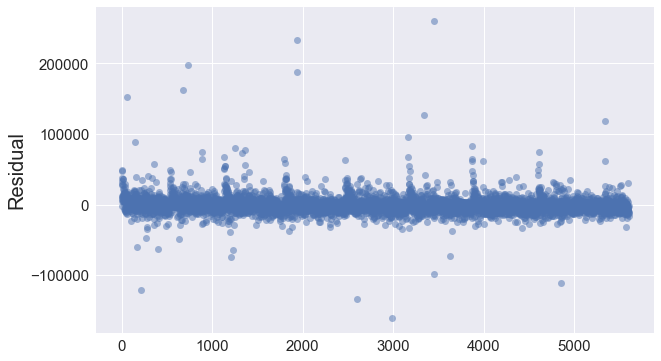

In [224]:
model = train_model('ridge', X, y);
evaluate_model(X, y)

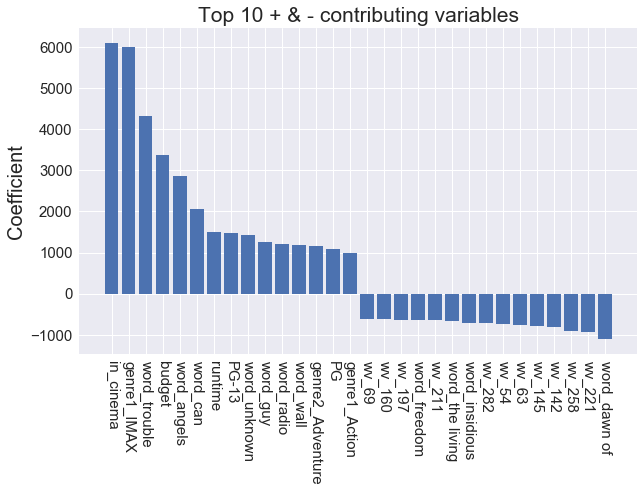

In [225]:
plot_most_relevant_features(model, column_names)

### Model D.2: Lasso

In [226]:
model = train_model('lasso', X_train, y_train);

R**2 : 0.39480086312516355
RMSE : 15598.978231352437


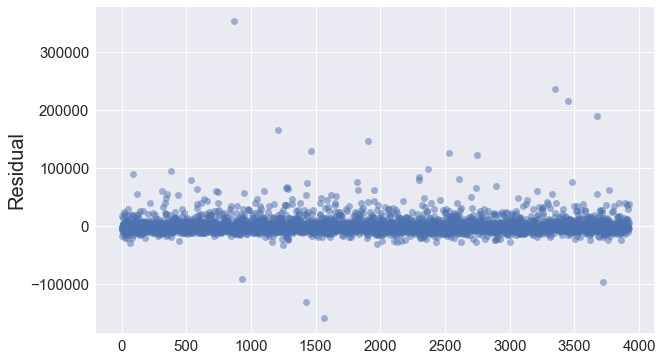

In [227]:
evaluate_model(X_train, y_train)

R**2 : 0.3396655021421685
RMSE : 16087.52589290319


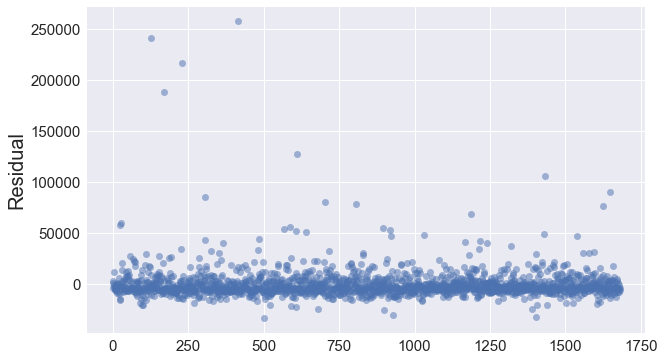

In [228]:
evaluate_model(X_test, y_test)

R**2 : 0.390910345757018
RMSE : 15589.846716015712


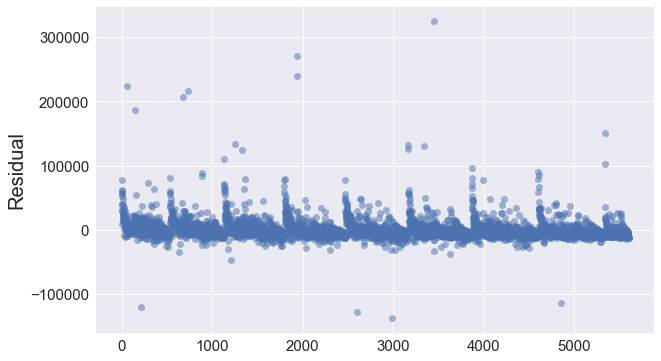

In [229]:
model = train_model('lasso', X, y);
evaluate_model(X, y)

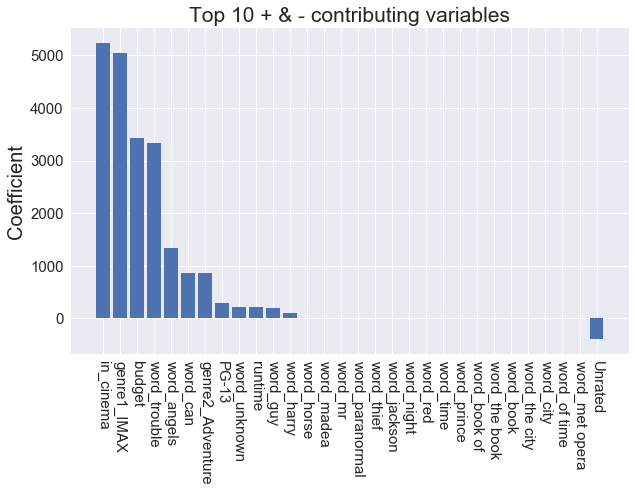

In [230]:
plot_most_relevant_features(model, column_names)

## Models E: Documentary, all features included

In [231]:
X_train, X_test, y_train, y_test, _ = split_dataset_for_genre(pc, 'Drama', w2v=True)
X, _, y, _, column_names = split_dataset_for_genre(pc, 'Drama', w2v=True, whole=True)

### Model E.1: Ridge

In [232]:
model = train_model('ridge', X_train, y_train);

R**2 : 0.5915382956689599
RMSE : 6963.110357027411


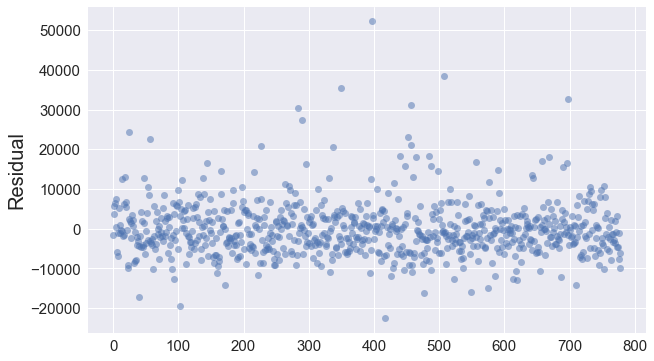

In [233]:
evaluate_model(X_train, y_train)

R**2 : -0.18887243948775945
RMSE : 10617.064170095102


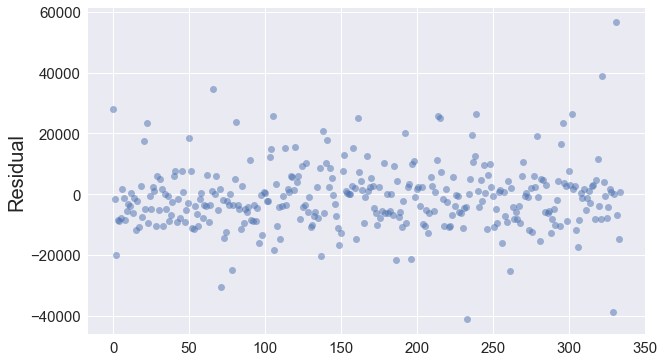

In [234]:
evaluate_model(X_test, y_test)

R**2 : 0.541359148527188
RMSE : 7159.460924875497


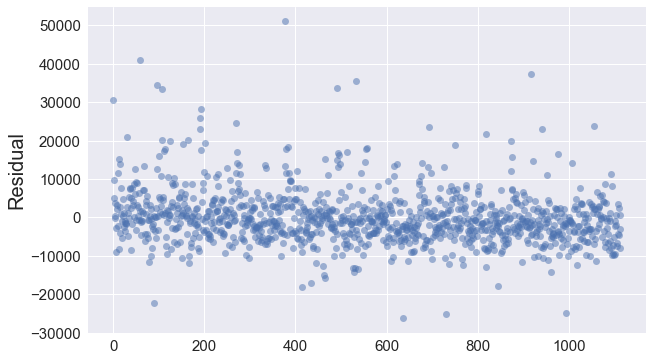

In [235]:
model = train_model('ridge', X, y);
evaluate_model(X, y)

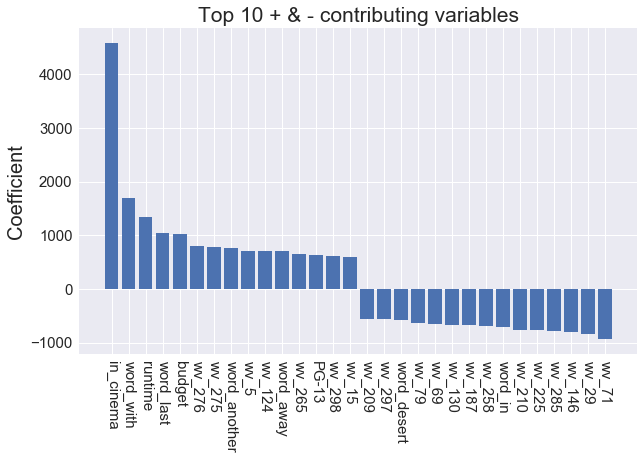

In [236]:
plot_most_relevant_features(model, column_names)

### Model E.2: Lasso

In [237]:
model = train_model('lasso', X_train, y_train);

R**2 : 0.3715102856304695
RMSE : 8637.273921942937


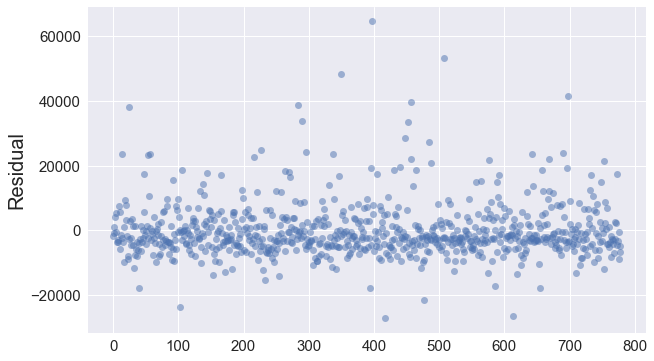

In [238]:
evaluate_model(X_train, y_train)

R**2 : 0.16150246320553263
RMSE : 8916.362325560835


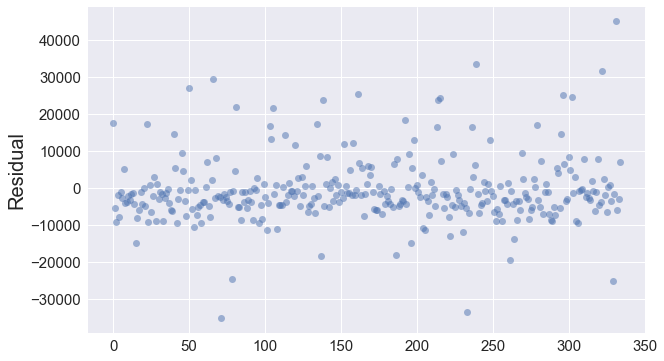

In [239]:
evaluate_model(X_test, y_test)

R**2 : 0.3390883785715264
RMSE : 8594.40172466128


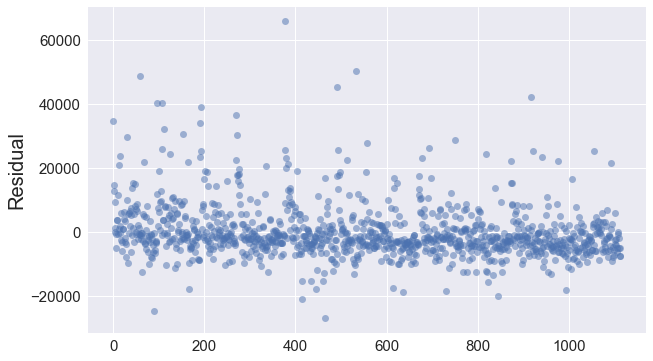

In [240]:
model = train_model('lasso', X, y);
evaluate_model(X, y)

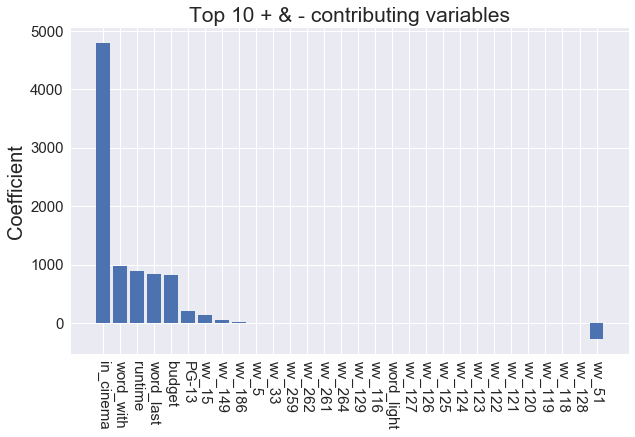

In [241]:
plot_most_relevant_features(model, column_names)

## Model F: Action, all features included

In [242]:
X_train, X_test, y_train, y_test, _ = split_dataset_for_genre(pc, 'Action', w2v=True)
X, _, y, _, column_names = split_dataset_for_genre(pc, 'Action', w2v=True, whole=True)

### Model F.1: Ridge

In [243]:
model = train_model('ridge', X_train, y_train);

R**2 : 0.8498577190841397
RMSE : 10307.470450581772


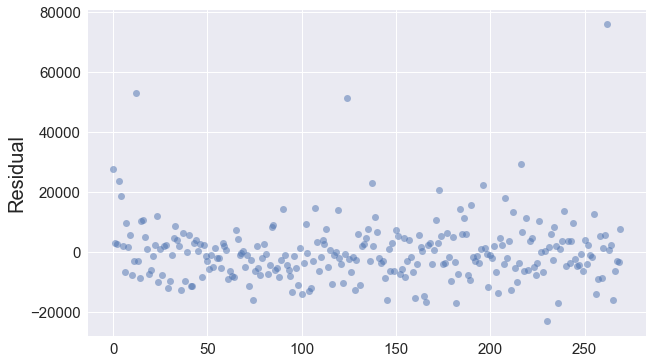

In [244]:
evaluate_model(X_train, y_train)

R**2 : 0.46568385013716596
RMSE : 21875.608067063033


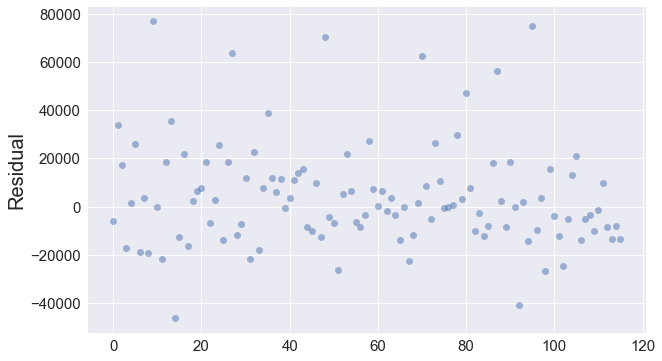

In [245]:
evaluate_model(X_test, y_test)

R**2 : 0.8465619007458961
RMSE : 10836.721672020265


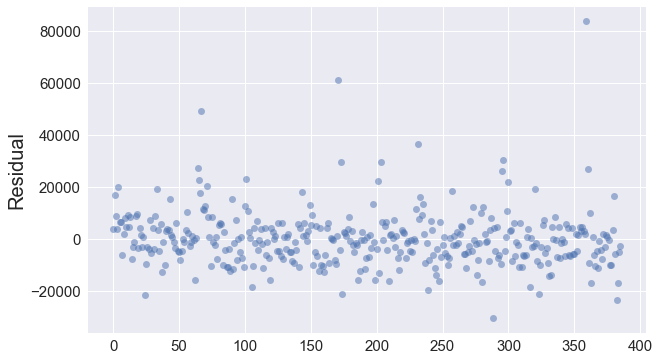

In [246]:
model = train_model('ridge', X, y);
evaluate_model(X, y)

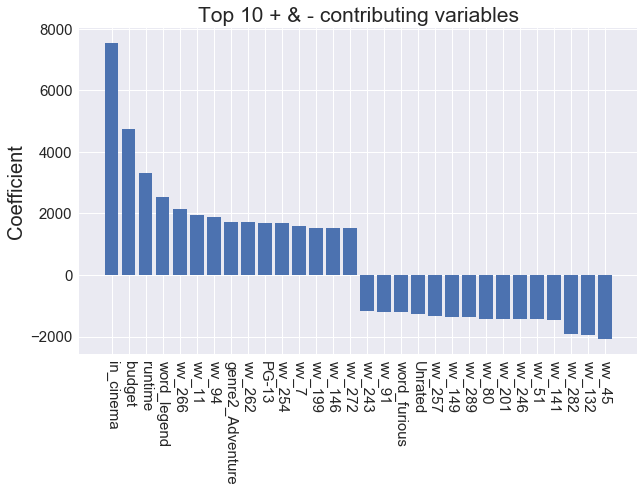

In [247]:
plot_most_relevant_features(model, column_names)

### Model F.2: Lasso

In [248]:
model = train_model('lasso', X_train, y_train);

/Users/piocalderon/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


R**2 : 0.5312319830035622
RMSE : 18212.920016234348


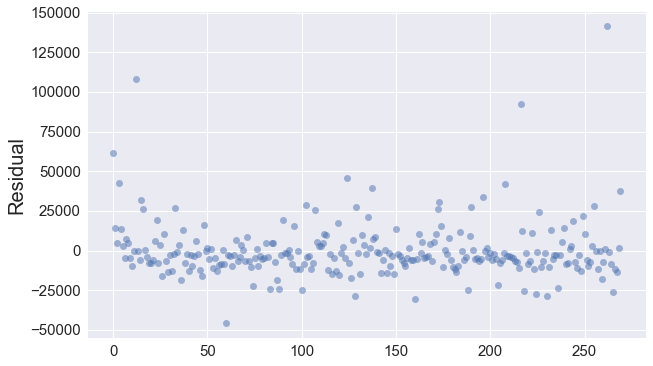

In [249]:
evaluate_model(X_train, y_train)

R**2 : 0.5795953195828016
RMSE : 19404.15586446981


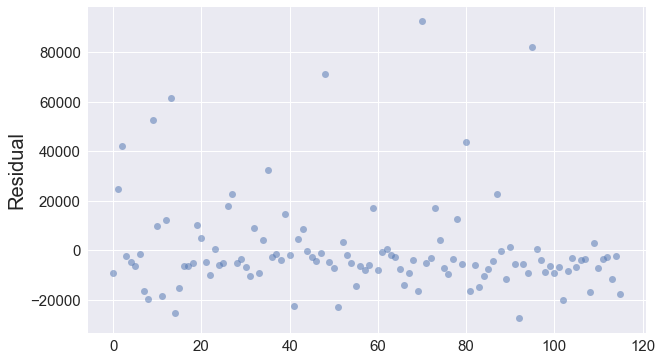

In [250]:
evaluate_model(X_test, y_test)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


R**2 : 0.6306032278408772
RMSE : 16814.26401306495


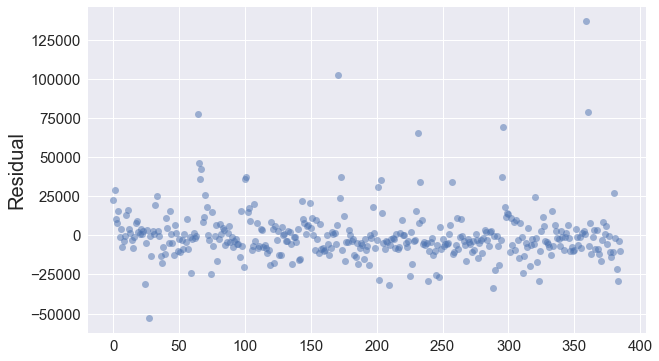

In [251]:
model = train_model('lasso', X, y);
evaluate_model(X, y)

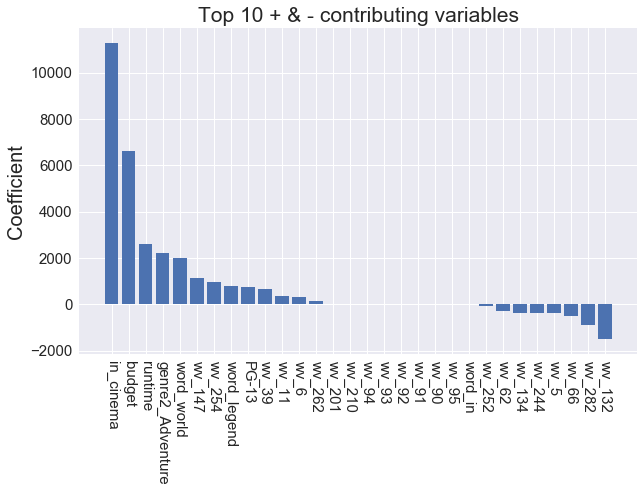

In [252]:
plot_most_relevant_features(model, column_names)

## 

## Conclusion

The words in the title capture some of the variance of the box office performance. However, from the preliminary analysis, it's apparent that the text alone is not enough to predict box office success (in terms of total gross per cinema) with high certainty. 

Based on our model without word2vec features, titles with 'trouble', 'angels', 'can', 'unknown' contribute to success, while title with 'dawn of', 'the living', 'freedom', 'the train' contribute to failure. It is also worth mentioning that the model for Action has relatively high R^2 both on train and test (~0.5) though high RMSE. Nevertheless it still shows promise that the textual content correlates with box office performance.

There are many other factors to success. Some other factors worth considering are:
* the actors and actresses involved (though this might be tied to the budget, but budget is mostly NaN in the dataset)
* the summary of the movie
* more temporal features (month, holiday, etc)
* more details about the movie (reviews of the movie; also, is the movie based on a book? is the movie tied to a famous event or person?)

Another recommendation is to treat the problem as a classification problem. It seems to be an easier problem to predict success or not success, but it would be quite subjective to define what success is. One idea I have is to define a movie as successful if it is profitable: if its revenue exceeds its budget.

Also, more meticulous hyperparameter selection is recommended (ex. n in n-grams, choosing tfidf hyperparameters, ridge/lasso alphas, etc.)